# FEATURE SELECTION

In [ ]:
df_train_final = pd.read_csv("df_train_final.csv")
df_test_final = pd.read_csv("df_test_final.csv")

In [ ]:
df_train_final

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,PA_FLAG_NA_GOODS_PRICE,PA_MAX_CREDIT_APP_RATIO,PA_AMT_ANNUITY_MAX,PA_DOWN_PAYMENT_MEAN,PA_AMT_GOODS_PRICE_SUM,PA_COUNT_TOTAL,PA_DAYS_DECISION_RECENT,PA_RECENCY_MEAN,PA_FLAG_CASH_LOAN,TARGET
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0.0,1.000000,9251.775,0.000,179055.000,1.0,-606.0,-606.000000,0.000000,1
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0.0,1.150980,98356.995,2295.000,435436.500,3.0,-746.0,-1305.000000,0.333333,0
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0.0,0.828021,5357.250,4860.000,24282.000,1.0,-815.0,-815.000000,0.000000,0
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,1.0,1.316797,39954.510,7742.260,272203.260,9.0,-181.0,-272.444444,0.555556,0
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0.0,1.264000,22678.785,1130.250,150530.250,6.0,-374.0,-1222.833333,0.666667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0.0,1.000000,6605.910,0.000,40455.000,1.0,-273.0,-273.000000,0.000000,0
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0.0,0.986561,10074.465,3456.000,57595.500,1.0,-2497.0,-2497.000000,0.000000,0
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0.0,0.944436,5567.715,4403.250,24162.750,2.0,-1909.0,-2380.000000,0.000000,0
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0.0,1.138491,19065.825,0.000,121317.750,2.0,-277.0,-299.500000,0.000000,1


In [ ]:
# Membersihkan nama kolom agar bisa digunakan pada model LightGBM

def clean_feature_names(df):
    """Membersihkan nama kolom dari karakter LightGBM/JSON yang sensitif."""
    new_cols = []
    for col in df.columns:
        col_clean = re.sub(r'[^A-Za-z0-9_]+', '_', col)

        col_clean = re.sub(r'_{2,}', '_', col_clean)
        col_clean = col_clean.strip('_')
        new_cols.append(col_clean)

    df.columns = new_cols
    return df
df_train_final = clean_feature_names(df_train_final)

In [ ]:
X = df_train_final.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df_train_final['TARGET']

# Pisahkan data untuk validasi
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

In [ ]:
# Pelatihan Model
model = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_val,
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# Ekstraksi Feature Importance
importance = model.feature_importance(importance_type='gain')


feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Urutkan berdasarkan Importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

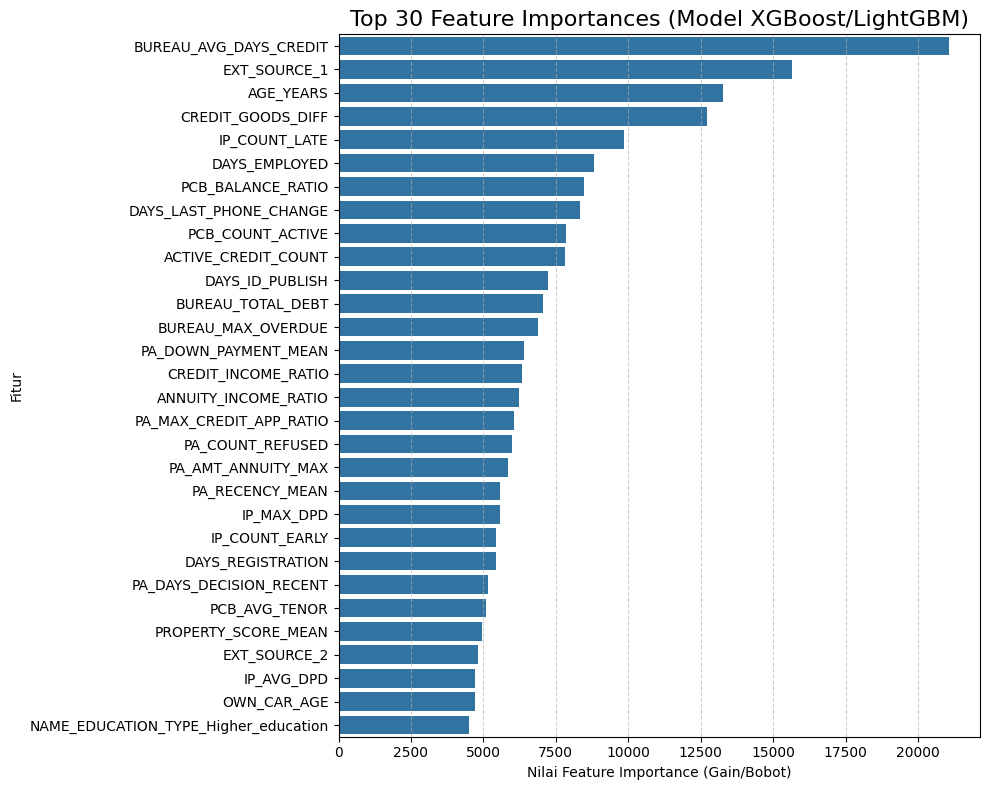

In [ ]:
# Pilih Top N Fitur (misalnya 30 teratas)
N = 30
top_n_features = feature_importance_df.head(N)

plt.figure(figsize=(10, 8))

# Buat Horizontal Bar Plot
sns.barplot(
    x='Importance',
    y='Feature',
    data=top_n_features.sort_values(by='Importance', ascending=False),
    color='#1f77b4'
)

plt.title(f'Top {N} Feature Importances (Model XGBoost/LightGBM)', fontsize=16)
plt.xlabel('Nilai Feature Importance (Gain/Bobot)')
plt.ylabel('Fitur')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Tampilkan 50 fitur paling penting
print(feature_importance_df.head(50))

                                  Feature    Importance
176                BUREAU_AVG_DAYS_CREDIT  21087.896952
147                          EXT_SOURCE_1  15664.984697
48                              AGE_YEARS  13283.337921
10                      CREDIT_GOODS_DIFF  12726.538194
187                         IP_COUNT_LATE   9850.252954
46                          DAYS_EMPLOYED   8826.331920
201                     PCB_BALANCE_RATIO   8474.347114
156                DAYS_LAST_PHONE_CHANGE   8348.876792
197                      PCB_COUNT_ACTIVE   7852.803788
171                   ACTIVE_CREDIT_COUNT   7821.600653
50                        DAYS_ID_PUBLISH   7215.513636
169                     BUREAU_TOTAL_DEBT   7045.301830
173                    BUREAU_MAX_OVERDUE   6880.086713
210                  PA_DOWN_PAYMENT_MEAN   6388.353844
8                     CREDIT_INCOME_RATIO   6316.013679
9                    ANNUITY_INCOME_RATIO   6224.191617
208               PA_MAX_CREDIT_APP_RATIO   6053

In [ ]:
# 1. Pastikan DataFrame terurut berdasarkan Importance (descending)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 2. Hitung Proporsi (Normalisasi)
total_importance = feature_importance_df['Importance'].sum()
feature_importance_df['Proporsi'] = feature_importance_df['Importance'] / total_importance

# 3. Hitung Proporsi Kumulatif
feature_importance_df['Kumulatif'] = feature_importance_df['Proporsi'].cumsum()

print("Daftar Fitur dengan Kontribusi Kumulatif:")
print(feature_importance_df.head(10))

Daftar Fitur dengan Kontribusi Kumulatif:
                  Feature    Importance  Proporsi  Kumulatif
0  BUREAU_AVG_DAYS_CREDIT  21087.896952  0.064415   0.064415
1            EXT_SOURCE_1  15664.984697  0.047850   0.112266
2               AGE_YEARS  13283.337921  0.040575   0.152841
3       CREDIT_GOODS_DIFF  12726.538194  0.038875   0.191716
4           IP_COUNT_LATE   9850.252954  0.030089   0.221805
5           DAYS_EMPLOYED   8826.331920  0.026961   0.248766
6       PCB_BALANCE_RATIO   8474.347114  0.025886   0.274652
7  DAYS_LAST_PHONE_CHANGE   8348.876792  0.025503   0.300154
8        PCB_COUNT_ACTIVE   7852.803788  0.023987   0.324141
9     ACTIVE_CREDIT_COUNT   7821.600653  0.023892   0.348033


In [ ]:
# Tentukan Ambang Batas 99%
AMBANG_BATAS = 0.99

# Temukan indeks baris pertama yang melampaui ambang batas 99%
cutoff_index = feature_importance_df[feature_importance_df['Kumulatif'] >= AMBANG_BATAS].index.min()

# Ambil semua fitur hingga indeks tersebut (termasuk indeks tersebut)
features_to_keep = feature_importance_df.loc[:cutoff_index, 'Feature'].tolist()

# Hitung jumlah fitur yang tersisa
jumlah_fitur_terpilih = len(features_to_keep)

print("-" * 50)
print(f"Ambang Batas Seleksi: {AMBANG_BATAS*100:.0f}%")
print(f"Jumlah Fitur yang Menyumbang {AMBANG_BATAS*100:.0f}%: {jumlah_fitur_terpilih} kolom")
print(f"Total Kumulatif Bobot yang Dipertahankan: {feature_importance_df.loc[cutoff_index, 'Kumulatif']:.4f}")
print("-" * 50)

--------------------------------------------------
✅ Ambang Batas Seleksi: 99%
Jumlah Fitur yang Menyumbang 99%: 128 kolom
Total Kumulatif Bobot yang Dipertahankan: 0.9900
--------------------------------------------------


In [ ]:
top_features = features_to_keep
top_features.append("SK_ID_CURR")
top_features.append("TARGET")